## [NYCDSA Capstone Project] 
# Women's Softball League Power Ranking Estimate

<br>
Koeun Lim (koeunlim@alum.mit.edu)<br>
Kevin Haghi (kevin.haghi@gmail.com)<br>


# Step 5. Modeling 1 - RPI Prediction

---
## Project Description



### Project Outline
- Step 1. Web scraping
- Step 2. Clean data
- Step 3. EDA
- Step 4. Imputation & PCA
- Step 5. Modeling (1) RPI prediction based on stats

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import xgboost as xgb
import sklearn.model_selection as ms

from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)

In [3]:
%store -r y_RPI
%store -r X_imp_KNN

In [4]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [5]:
y = y_RPI
X = X_imp_KNN.copy()
X = X.drop(columns=['WL_Percentage'])
X.head()

,Year,Fielding_Percentage,Scoring,Hit_Batters,Earned_Run_Average,Triples_per_Game,Home_Runs_per_game,Slugging_Percentage,Double_Plays_per_Game,On_Base_Percentage,Stolen_Bases_per_Game,Strikeout-to-Walk_Ratio,Batting_Average,Doubles_per_Game,Shutouts,Team_Strikeouts_Per_Seven_Innings,Conf__ACC,Conf__ASUN,Conf__America East,Conf__Atlantic 10,Conf__Big 12,Conf__Big East,Conf__Big Sky,Conf__Big South,Conf__Big Ten,Conf__Big West,Conf__C-USA,Conf__CAA,Conf__Horizon,Conf__IVY,Conf__Ivy,Conf__MAAC,Conf__MAC,Conf__MEAC,Conf__MVC,Conf__MWC,Conf__NEC,Conf__OVC,Conf__Pac-12,Conf__Patriot,Conf__SEC,Conf__SWAC,Conf__SoCon,Conf__Southland,Conf__Summit,Conf__Sun Belt,Conf__WAC,Conf__WCC
0,2019.0,0.984,7.30,14.0,1.40,0.30,1.83,0.639,0.25,0.435,0.97,6.50,0.344,1.60,28.0,7.098,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019.0,0.974,7.03,42.0,1.43,0.21,1.26,0.547,0.23,0.416,0.98,5.52,0.339,1.45,20.0,7.160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019.0,0.980,5.25,24.0,1.47,0.15,0.79,0.440,0.21,0.383,0.80,5.79,0.297,1.20,24.0,7.328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019.0,0.976,6.48,22.0,1.61,0.11,1.77,0.570,0.29,0.398,0.23,3.71,0.318,1.18,15.0,7.328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019.0,0.973,6.98,32.0,1.87,0.28,1.62,0.601,0.37,0.421,1.77,3.74,0.330,1.58,22.0,7.216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [7]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2, 5, 10],
    'gamma': [0, 1, 2, 5],
    'reg_alpha': [0],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'random_state' :[1]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',nthread= -1,gpu_id=-1)

In [8]:
folds = 5
param_comb = 100

random_search1 = RandomizedSearchCV(
    xg_reg, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv=folds, 
    verbose=4
)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search1.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Time taken: 0 hours 3 minutes and 27.47 seconds.


In [9]:
print('\n All results:')
print(random_search1.cv_results_)
print('\n\n Best estimator:')
print(random_search1.best_estimator_)
print('\n\n Best rmse %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(-random_search1.best_score_)
print('\n\n Best R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X)))
print('\n\n Best hyperparameters:')
print(random_search1.best_params_)
results1 = pd.DataFrame(random_search1.cv_results_).sort_values('rank_test_score', ascending=True)
results1.to_csv('XGBoost/xgb-random-grid-search-results-train_famd01.csv', index=False)


 All results:
{'mean_fit_time': array([0.87085166, 1.5595788 , 1.69211273, 1.43985095, 1.92065983,
       0.67711754, 0.73693767, 1.31796894, 0.97490778, 2.55830641,
       1.29011402, 1.03249912, 1.40944128, 1.61142521, 0.81121321,
       0.79111781, 1.33526902, 2.03332934, 1.51582723, 1.09796557,
       1.38561687, 0.8632515 , 0.53934159, 2.30832386, 1.94722929,
       1.00575118, 1.49503455, 1.16435304, 1.6431366 , 2.41398005,
       1.14520774, 1.40163174, 1.42966704, 1.34628115, 1.77022476,
       2.16038446, 2.825386  , 1.47380428, 1.27850261, 1.12777667,
       1.73873734, 3.30534339, 1.80872774, 0.83722997, 1.27913399,
       2.04034338, 0.91190724, 1.06545882, 2.4412436 , 2.1616343 ,
       0.51403313, 1.89799976, 2.38440123, 0.66672387, 1.20863609,
       2.36463833, 1.7008008 , 1.61783423, 0.84798875, 2.42829204,
       3.44537225, 2.75222058, 0.59516196, 2.97805347, 1.10246863,
       0.99937048, 0.65969987, 0.89206605, 0.71303282, 1.53359404,
       1.94443774, 1.2430017 



Best Train R_squared 5-fold search with 100 parameter combinations:
0.9705404889925252


Best Test R_squared 5-fold search with 100 parameter combinations:
0.8307954606865458


Best R_squared 5-fold search with 100 parameter combinations:
0.9428998177155365


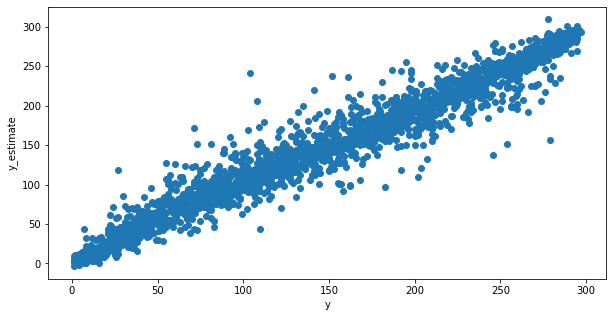

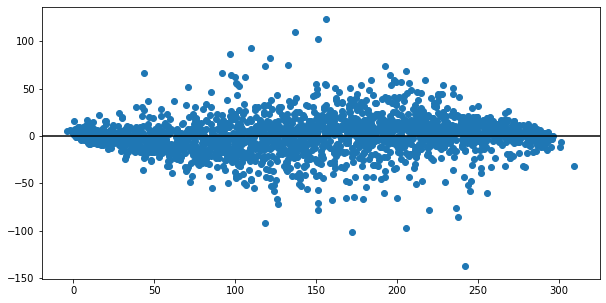

In [10]:
print('\n\nBest Train R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_train, random_search1.predict(X_train)))
print('\n\nBest Test R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y_test, random_search1.predict(X_test)))
print('\n\nBest R_squared %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(r2_score(y, random_search1.predict(X)))

plt.rcParams['figure.figsize'] = [10, 5]

plt.scatter(y,random_search1.predict(X))
plt.xlabel('y')
plt.ylabel('y_estimate')
plt.show()

plt.scatter(random_search1.predict(X),y-random_search1.predict(X))
plt.axhline(color='black')
plt.show()

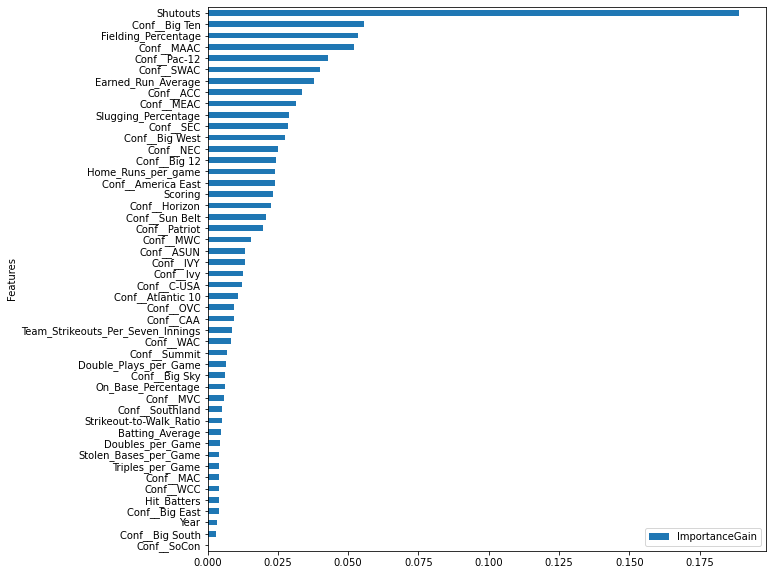

,Features,ImportanceGain,CummulativeGain
14,Shutouts,0.188972,0.188972
24,Conf__Big Ten,0.055512,0.244483
1,Fielding_Percentage,0.053479,0.297962
31,Conf__MAAC,0.052035,0.349997
38,Conf__Pac-12,0.042881,0.392877
41,Conf__SWAC,0.040130,0.433007
4,Earned_Run_Average,0.037980,0.470987
16,Conf__ACC,0.033733,0.504720
33,Conf__MEAC,0.031477,0.536197
7,Slugging_Percentage,0.028935,0.565133


In [11]:
feature_importance1 = pd.DataFrame(X.columns)
feature_importance1.columns = ['Features']
feature_importance1['ImportanceGain'] = random_search1.best_estimator_.feature_importances_
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1['CummulativeGain'] = feature_importance1.ImportanceGain.cumsum()

plt.rcParams['figure.figsize'] = (10, 10)
feature_importance1 = feature_importance1.sort_values('ImportanceGain', ascending=False)
feature_importance1.sort_values('ImportanceGain', ascending=True).plot(x='Features',y='ImportanceGain',kind='barh')
plt.show()

feature_importance1